In [1]:
# importar librerias
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import ast # tranforma a lista

/kaggle/input/data-analyst-job-postings-google-search/gsearch_jobs.csv


# 1. Extract and check the data

In [2]:
# read the data
df_raw = pd.read_csv('/kaggle/input/data-analyst-job-postings-google-search/gsearch_jobs.csv')


* to delete: ['Unnamed: 0','index', 'job_id']
* others columns: ['company_name', 'location', 'via', 'description', 'extensions']
* to use:  ['description_tokens', 'posted_at', 'date_time']
* to check: ['title', 'search_location', 'location', 'posted_at', 'search_term']

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61953 entries, 0 to 61952
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           61953 non-null  int64  
 1   index                61953 non-null  int64  
 2   title                61953 non-null  object 
 3   company_name         61953 non-null  object 
 4   location             61916 non-null  object 
 5   via                  61944 non-null  object 
 6   description          61953 non-null  object 
 7   extensions           61953 non-null  object 
 8   job_id               61953 non-null  object 
 9   thumbnail            38194 non-null  object 
 10  posted_at            61763 non-null  object 
 11  schedule_type        61707 non-null  object 
 12  work_from_home       27980 non-null  object 
 13  salary               10088 non-null  object 
 14  search_term          61953 non-null  object 
 15  date_time            61953 non-null 

* Check others columns to decide: 
    * Hace cuanto tiempo fues posteado no me interera **posted_at**
    * Me interesa la fecha del post **date_time**
    * **description_tokens** algunos vacios los eliminare
    * **location** no usare porque todo es USA
    * title los titulos de rol pueden variar pero el rol puede ser uno solo, no me sirve **title**
    * solo busqueda de DA, no me sirve **search_term**

In [4]:
df_raw[['title', 'search_location','location', 'posted_at','search_term', 'description_tokens', 'date_time']]

,title,search_location,location,posted_at,search_term,description_tokens,date_time
0,Data Analyst,United States,Anywhere,15 hours ago,data analyst,"['tableau', 'r', 'python', 'sql']",2023-08-04 03:00:13.797776
1,Data Analyst,United States,United States,12 hours ago,data analyst,[],2023-08-04 03:00:13.797776
2,Aeronautical Data Analyst,United States,"Olathe, KS",18 hours ago,data analyst,['sql'],2023-08-04 03:00:13.797776
3,Data Analyst - Consumer Goods - Contract to Hire,United States,Anywhere,12 hours ago,data analyst,"['powerpoint', 'excel', 'power_bi']",2023-08-04 03:00:13.797776
4,Data Analyst | Workforce Management,United States,United States,7 hours ago,data analyst,"['powerpoint', 'excel', 'outlook', 'word']",2023-08-04 03:00:13.797776
...,...,...,...,...,...,...,...
61948,Marketing Data & BI Analyst II,United States,"Houstonia, MO",23 hours ago,data analyst,"['power_bi', 'tableau', 'excel', 'snowflake', ...",2022-11-04 03:40:23.706734
61949,Lead-Data Analyst,United States,"Marshfield, MO",23 hours ago,data analyst,[],2022-11-24 04:00:08.710801
61950,Lead-Data Analyst,United States,"High Point, MO",23 hours ago,data analyst,[],2022-12-07 04:00:12.563831
61951,Lead-Data Analyst,United States,"Calhoun, MO",23 hours ago,data analyst,[],2022-12-08 04:00:15.975728


In [5]:
for i in ['title', 'search_location', 'location', 'search_term']:
    print(f'Datos únicos de {i}:', df_raw[i].unique())                          

Datos únicos de title: ['Data Analyst' 'Aeronautical Data Analyst'
 'Data Analyst - Consumer Goods - Contract to Hire' ...
 'Data Analyst - Business Intelligence' 'COOP - Senior Data Analyst'
 'Lead FP&A Analyst- Remote, US']
Datos únicos de search_location: ['United States']
Datos únicos de location: [' Anywhere ' '  United States   ' '  Olathe, KS   ' ... 'Eudora, MO'
 'Marionville, MO' 'Salem, MO']
Datos únicos de search_term: ['data analyst']


# 2. Define el dataset final

Acomodar el dataset para trabajarlo
1. la columna description_tokens no esta como lista, hay que transformarlo
2. elimino las listas vacias, las que no tienen skills
3. separo los skills de la lista
4. tranformar la columna date_time a fechas y mes
5. ordeno los skills segun fecha de aparacion

In [6]:
df = (df_raw[['description_tokens', 'date_time']]
    .assign(skills = lambda df: df['description_tokens'].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else [])) # tranformacion a lista
    .loc[lambda df: df['skills'].str.len() > 0] #elimino tokens vacios y como esta con string esta contango 2 [ y ]
    .explode('skills')
    .assign(date_time = lambda df: pd.to_datetime(df['date_time']).dt.to_period('M')) # tranformo y obengo solo meses
    .sort_values(['date_time'])# ordenar ates de agrupar
)[['date_time', 'skills']]
#['skills'].unique() revisar limpieza

df.head(5)

,date_time,skills
57258,2022-11,looker
39299,2022-11,microstrategy
39299,2022-11,python
39299,2022-11,r
39299,2022-11,nosql


* Tranformar con dummies la columna skills
* Agrupamos segun la fecha de poste del trabajo
* sumamos la frecuencia de los skills

In [7]:
# sacando dummies y agrupando segfun fecha los skills
skills_month = (pd.get_dummies(df['skills']) # en columnas
    .groupby(df['date_time'].dt.strftime('%Y-%m'),  sort=False) #agrupa por fecha modostring para usarlo mas adelante
    .sum() 
    .reset_index()
)

skills_month.head(5)

,date_time,airflow,alteryx,apl,asp.net,assembly,atlassian,aurora,aws,azure,...,ubuntu,unix,unix/linux,vb.net,vba,visio,visual_basic,vue,vue.js,word
0,2022-11,19,45,0,3,4,6,4,133,124,...,0,14,3,1,104,31,5,0,0,150
1,2022-12,38,93,0,3,3,14,3,196,179,...,0,24,7,2,49,36,10,6,1,233
2,2023-01,24,126,1,6,8,7,4,193,231,...,0,26,5,2,64,34,28,1,0,295
3,2023-02,16,104,3,2,17,8,2,217,148,...,0,22,2,1,67,35,20,2,1,250
4,2023-03,19,75,2,0,5,6,10,143,107,...,0,17,2,3,72,36,14,0,0,216


* Ahora necesito analizar como han crecido la frecuencia del skill de un mes a otro
* creo una funcion crecimiento y aplico a mi dataset

In [8]:
# Crecimiento mes a mes
def crecimiento(df):
    return (        
        df.set_index('date_time') #regreso a DT
        .pct_change(periods=1)
        .mul(100)
        #.replace([np.inf, -np.inf], np.nan)
        .replace([np.inf, -np.inf], [100, -100]) #el maximo sera 100 y el minimo -100
        .fillna(0) 
        .reset_index()
    )

skills_crecimiento = crecimiento(skills_month)
skills_crecimiento.head(5)

,date_time,airflow,alteryx,apl,asp.net,assembly,atlassian,aurora,aws,azure,...,ubuntu,unix,unix/linux,vb.net,vba,visio,visual_basic,vue,vue.js,word
0,2022-11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,2022-12,100.000000,106.666667,0.000000,0.000000,-25.000000,133.333333,-25.000000,47.368421,44.354839,...,0.0,71.428571,133.333333,100.0,-52.884615,16.129032,100.000000,100.000000,100.0,55.333333
2,2023-01,-36.842105,35.483871,100.000000,100.000000,166.666667,-50.000000,33.333333,-1.530612,29.050279,...,0.0,8.333333,-28.571429,0.0,30.612245,-5.555556,180.000000,-83.333333,-100.0,26.609442
3,2023-02,-33.333333,-17.460317,200.000000,-66.666667,112.500000,14.285714,-50.000000,12.435233,-35.930736,...,0.0,-15.384615,-60.000000,-50.0,4.687500,2.941176,-28.571429,100.000000,100.0,-15.254237
4,2023-03,18.750000,-27.884615,-33.333333,-100.000000,-70.588235,-25.000000,400.000000,-34.101382,-27.702703,...,0.0,-22.727273,0.000000,200.0,7.462687,2.857143,-30.000000,-100.000000,-100.0,-13.600000


* Quiero los skills que mas se repitan dentro del dataset (de 3 a mas veces) =  skill repetidos
* Estos skills los voy a filtrar de todo el dataset y se llamaran skills_top

In [9]:
# habiliades repetidas
skills_rep = skills_month.groupby('date_time').sum()
skills_top = skills_rep.columns[skills_rep.iloc[0] >=3]
print(skills_top)

Index(['airflow', 'alteryx', 'asp.net', 'assembly', 'atlassian', 'aurora',
       'aws', 'azure', 'bash', 'bigquery', 'bitbucket', 'c', 'c++', 'cobol',
       'cognos', 'crystal', 'css', 'dax', 'docker', 'dplyr', 'excel', 'gcp',
       'gdpr', 'git', 'github', 'go', 'hadoop', 'html', 'java', 'javascript',
       'jira', 'jquery', 'julia', 'jupyter', 'keras', 'linux', 'looker',
       'matlab', 'matplotlib', 'microstrategy', 'mongodb', 'mssql', 'mysql',
       'nosql', 'numpy', 'outlook', 'pandas', 'php', 'pl/sql', 'plotly',
       'postgres', 'postgresql', 'power_bi', 'powerpoint', 'powershell',
       'pyspark', 'python', 'pytorch', 'qlik', 'r', 'redshift', 'ruby', 'sap',
       'sas', 'scala', 'scikit-learn', 'seaborn', 'sharepoint', 'shell',
       'snowflake', 'spark', 'splunk', 'spreadsheet', 'spss', 'sql', 'ssis',
       'ssrs', 't-sql', 'tableau', 'tensorflow', 'terminal', 'unix',
       'unix/linux', 'vba', 'visio', 'visual_basic', 'word'],
      dtype='object')


* De mi dataframe de crecimiento filtro los skills top

In [10]:
skills_top_crecimiento = skills_crecimiento[skills_top]

# 3. Definir metricas de crecimiento

1. **crec_mean**: crecimiento promedio mensual histórico 
2. **crec_mean_3**: promedio de los últimos 3 meses (alto ruido).
3. **crec_mean_6**: media de los últimos 6 meses (tendencia media).
4. **volatil**: desviación estándar del crecimiento mensual.
5. **frecuencia**: ocurrencias en el último mes.

In [11]:
# axis = 0 skills en columnas no enfilas
skills_metricas = pd.DataFrame({
    'crec_mean': skills_top_crecimiento.mean(), #crecimiento sostenido
    'crec_mean_3': skills_top_crecimiento.iloc[-3:].mean(),  # Últimos 3 meses demasiado volatil
    'crec_mean_6': skills_top_crecimiento.iloc[-6:].mean(),  # Últimos 6 meses
    'volatil': skills_top_crecimiento.std(),
    'frecuencia': skills_month[skills_top].iloc[-1],# que se mencione una skill top (mas repetida)
    
})

skills_metricas = (skills_metricas
 .reset_index()
 .rename(columns={'index':'skill'})
 #.query('skill not in ["word", "outlook", "powerpoint"]') #para probar
)

skills_metricas.sort_values('crec_mean', ascending = False)

,skill,crec_mean,crec_mean_3,crec_mean_6,volatil,frecuencia
22,gdpr,107.715984,-32.586207,435.095785,524.406638,2
39,microstrategy,79.165873,19.841270,213.253968,316.865150,4
57,pytorch,71.885748,-20.809179,-7.150621,320.434092,5
4,atlassian,52.848933,-33.333333,52.777778,171.653899,1
47,php,49.038883,92.129630,24.041005,150.916060,3
...,...,...,...,...,...,...
67,sharepoint,0.187982,-23.579545,2.420754,28.577412,13
63,sas,0.093796,-12.884801,9.347635,33.953742,79
52,power_bi,-0.356565,-16.382366,9.598125,26.065797,252
59,r,-1.315735,-15.121409,6.893518,25.008654,148


In [12]:
skills_metricas.describe()

,crec_mean,crec_mean_3,crec_mean_6,volatil,frecuencia
count,87.000000,87.000000,87.000000,87.000000,87.000000
mean,19.939971,-1.847952,30.878717,98.296279,34.287356
std,18.527113,39.708531,56.011300,72.602605,77.194696
min,-1.609101,-66.648746,-18.166667,22.312882,0.000000
25%,6.665788,-21.094691,9.448453,55.808582,3.000000
50%,17.200856,-11.647993,14.842042,84.526314,10.000000
75%,28.255700,6.126634,30.573362,121.737386,22.500000
max,107.715984,255.555556,435.095785,524.406638,492.000000


# 4. Analisis de las metricas creadas

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

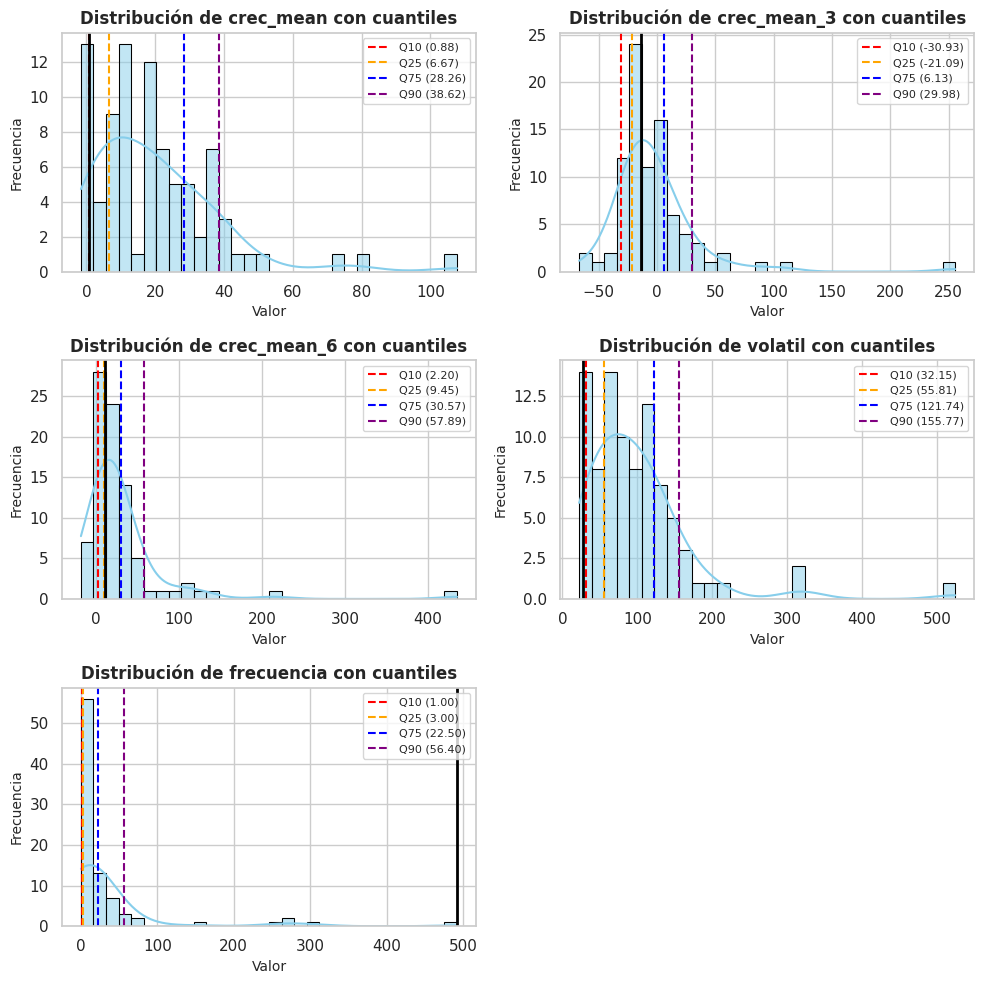

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns


# Configura el estilo y tamaño de los gráficos
sns.set(style="whitegrid")
plt.figure(figsize=(10,10))

# Lista de columnas a visualizar (excluyendo 'skill')
metricas = ['crec_mean', 'crec_mean_3', 'crec_mean_6', 'volatil', 'frecuencia']

for i, columna in enumerate(metricas, 1):
    plt.subplot(3, 2, i)
    sns.histplot(skills_metricas[columna], bins=30, kde=True, color='skyblue', edgecolor='black')
    
    # Calcular cuantiles (Q10, Q25, Q75, Q90)
    q10 = skills_metricas[columna].quantile(0.10)
    q25 = skills_metricas[columna].quantile(0.25)
    q75 = skills_metricas[columna].quantile(0.75)
    q90 = skills_metricas[columna].quantile(0.90)
    
    # Añadir líneas verticales con etiquetas
    plt.axvline(q10, color='red', linestyle='--', linewidth=1.5, label=f'Q10 ({q10:.2f})')
    plt.axvline(q25, color='orange', linestyle='--', linewidth=1.5, label=f'Q25 ({q25:.2f})')
    plt.axvline(q75, color='blue', linestyle='--', linewidth=1.5, label=f'Q75 ({q75:.2f})')
    plt.axvline(q90, color='purple', linestyle='--', linewidth=1.5, label=f'Q90 ({q90:.2f})')
    
    # Personalización
    plt.title(f'Distribución de {columna} con cuantiles', fontsize=12, fontweight='bold')
    plt.xlabel('Valor', fontsize=10)
    plt.ylabel('Frecuencia', fontsize=10)
    plt.legend(loc='upper right', fontsize=8)
    
    skill_blockchain = skills_metricas[skills_metricas['skill'] == 'sql']
    plt.axvline(skill_blockchain[columna].values[0], color='black', linewidth=2, linestyle='-', label='sql')

plt.tight_layout()  # Ajustar espaciado entre subplots
plt.show()

# 5. Definimos nuestro grupo de skills


## 5.1 Skills emergentes


In [14]:
emergentes = skills_metricas[(skills_metricas['crec_mean_3'] >  skills_metricas['crec_mean_3'].quantile(0.60)) &
                (skills_metricas['crec_mean_6'] > skills_metricas['crec_mean_6'].quantile(0.60)) &
                (skills_metricas['volatil'] < skills_metricas['volatil'].quantile(0.50)) &
                (skills_metricas['frecuencia'] > skills_metricas['frecuencia'].quantile(0.60)) 
]
emergentes

,skill,crec_mean,crec_mean_3,crec_mean_6,volatil,frecuencia
1,alteryx,12.233107,4.236384,27.917726,65.798397,24
17,dax,15.820792,28.629630,28.227858,69.537562,19
72,spreadsheet,4.881709,3.446227,36.082088,43.472195,33


## 5.2 Skills Maduras

In [15]:
maduras = skills_metricas[(skills_metricas['crec_mean'] >= 0) &
                (skills_metricas['volatil'] < skills_metricas['volatil'].quantile(0.20)) &
                (skills_metricas['frecuencia'] > skills_metricas['frecuencia'].quantile(0.80)) 
                ]
maduras.sort_values('frecuencia',ascending=False)

,skill,crec_mean,crec_mean_3,crec_mean_6,volatil,frecuencia
74,sql,0.702078,-14.023325,11.275314,27.789884,492
20,excel,0.213476,-16.062800,14.352588,29.449410,305
56,python,0.324337,-16.651178,7.641164,25.586284,278
78,tableau,0.688953,-14.755138,14.842042,29.403112,272
63,sas,0.093796,-12.884801,9.347635,33.953742,79
86,word,1.612547,4.687812,13.429052,29.039080,76
53,powerpoint,3.319182,-11.986622,10.078118,39.727242,60
69,snowflake,1.843037,-16.641414,9.605081,35.330203,54
7,azure,3.903861,-5.227205,14.047653,36.442141,52
6,aws,1.797854,-19.275620,-0.545235,36.351943,40


## 5.3 Skills de nichos

In [16]:
# Skills de nicho
nicho = skills_metricas[(skills_metricas['crec_mean_6'] >  skills_metricas['crec_mean_6'].quantile(0.20)) &
                (skills_metricas['volatil'] < skills_metricas['volatil'].quantile(0.60)) &
                (skills_metricas['frecuencia'] < skills_metricas['frecuencia'].quantile(0.40)) 
        ].sort_values('frecuencia', ascending=False)
nicho

,skill,crec_mean,crec_mean_3,crec_mean_6,volatil,frecuencia
68,shell,21.598935,-11.153846,63.470696,98.619894,6
13,cobol,12.101806,49.206349,41.269841,80.990839,2
81,unix,10.246993,21.666667,24.722222,57.357689,2
3,assembly,17.597185,-16.666667,13.888889,89.004907,1
66,seaborn,17.739043,-27.222222,11.388889,71.391824,1
16,css,9.915861,-27.777778,9.444444,67.866320,0
19,dplyr,8.576481,-61.538462,38.675214,83.932128,0
32,julia,11.149425,-33.333333,16.666667,84.455661,0
82,unix/linux,9.704433,-44.444444,11.111111,92.801781,0


## 5.4 Skills en Declive

In [17]:
# skills declive
declive = skills_metricas[(skills_metricas['crec_mean_6'] <  skills_metricas['crec_mean_6'].quantile(0.25)) &
                (skills_metricas['volatil'] > skills_metricas['volatil'].quantile(0.50)) &
                (skills_metricas['frecuencia'] > skills_metricas['frecuencia'].quantile(0.60)) 
].sort_values('frecuencia', ascending=False)
declive

,skill,crec_mean,crec_mean_3,crec_mean_6,volatil,frecuencia
29,javascript,16.861574,-7.347156,7.866948,89.251871,34
60,redshift,18.165059,-15.912698,9.024382,93.611885,22


# 6. Vista grafica de los grupos

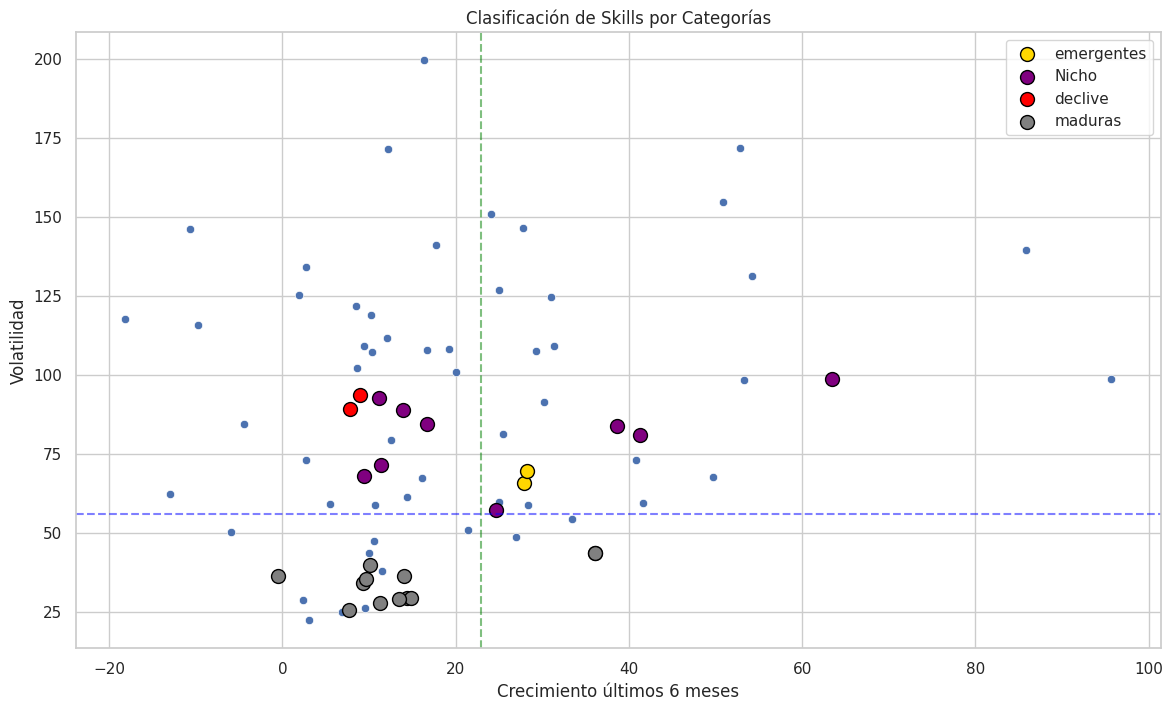

In [18]:
plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=skills_metricas.query('crec_mean_6<100 and volatil<200'),
    x='crec_mean_6',
    y='volatil',
    #hue='frecuencia',
    #size='frecuencia',
    #palette='viridis',
    sizes=(10, 100)
)

# Destacar categorías
plt.scatter(
    emergentes['crec_mean_6'],
    emergentes['volatil'],
    color='gold',
    s=100,
    edgecolor='black',
    label='emergentes'
)
plt.scatter(
    nicho['crec_mean_6'],
    nicho['volatil'],
    color='purple',
    s=100,
    edgecolor='black',
    label='Nicho'
)
plt.scatter(
    declive['crec_mean_6'],
    declive['volatil'],
    color='red',
    s=100,
    edgecolor='black',
    label='declive'
)
plt.scatter(
    maduras['crec_mean_6'],
    maduras['volatil'],
    color='gray',
    s=100,
    edgecolor='black',
    label='maduras'
)

plt.axhline(skills_metricas['volatil'].quantile(0.25), color='blue', linestyle='--', alpha=0.5)
plt.axvline(skills_metricas['crec_mean_6'].quantile(0.60), color='green', linestyle='--', alpha=0.5)
plt.xlabel('Crecimiento últimos 6 meses')
plt.ylabel('Volatilidad')
plt.title('Clasificación de Skills por Categorías')
plt.legend()
plt.show()
